# Robot Maintenance Failure Prediction

This notebook builds a **15‑minute early‑warning model** that predicts whether the robot will raise a non‑`OK` error within the next 15 minutes.

In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
import joblib


In [2]:

DATA_PATH = Path('robot_maintenancecsv.csv')  # same file you used
df = pd.read_csv(DATA_PATH)

# Ensure timestamp is datetime and ordered
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print('Loaded', df.shape[0], 'rows')
df.head()


Loaded 500 rows


,timestamp,battery_percent,battery_voltage,cpu_temp_c,motor_current_a,task_load,operating_hours,error_code,date,time
0,2025-06-29 09:00:00,100.0,16.85,61.2,3.53,0.68,0.00,OK,2025-06-29,09:00:00
1,2025-06-29 09:01:00,99.9,16.88,57.0,3.11,0.58,0.02,OK,2025-06-29,09:01:00
2,2025-06-29 09:02:00,100.0,16.73,51.5,2.18,0.41,0.03,OK,2025-06-29,09:02:00
3,2025-06-29 09:03:00,100.0,16.83,48.1,1.52,0.27,0.05,OK,2025-06-29,09:03:00
4,2025-06-29 09:04:00,99.7,16.71,56.0,2.71,0.54,0.07,OK,2025-06-29,09:04:00


In [3]:

LOOKAHEAD = 15  # minutes
# Future error flag
df['future_error'] = df['error_code'].shift(-LOOKAHEAD).apply(lambda x: 0 if x == 'OK' else 1)
df = df.dropna(subset=['future_error'])
df['future_error'] = df['future_error'].astype(int)
print('Positive class ratio:', df['future_error'].mean().round(3))


Positive class ratio: 0.048


In [4]:

# Basic time‑based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Rolling stats (5‑min window)
roll_cols = ['battery_percent', 'battery_voltage', 'cpu_temp_c', 'motor_current_a', 'task_load']
for col in roll_cols:
    df[f'{col}_mean5'] = df[col].rolling(window=5, min_periods=1).mean()
    df[f'{col}_std5'] = df[col].rolling(window=5, min_periods=1).std()

# Deltas
for col in roll_cols:
    df[f'{col}_diff1'] = df[col].diff()

# Drop rows with any remaining NaN
df = df.dropna()
print('After feature engineering:', df.shape)


After feature engineering: (499, 28)


In [5]:

FEATURES = [c for c in df.columns if c not in ['timestamp', 'error_code', 'future_error', 'date', 'time']]
X = df[FEATURES]
y = df['future_error']

# Time‑based split: last 20% for test
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Train size: (399, 23) Test size: (100, 23)


In [6]:

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

Classification report:
              precision    recall  f1-score   support

           0      0.840     1.000     0.913        84
           1      0.000     0.000     0.000        16

    accuracy                          0.840       100
   macro avg      0.420     0.500     0.457       100
weighted avg      0.706     0.840     0.767       100



C:\Users\Suraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Suraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Suraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

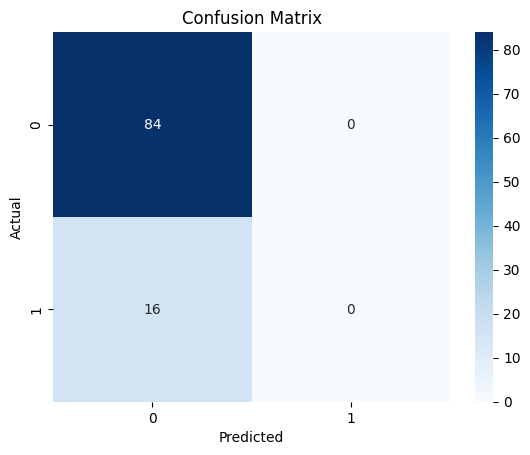

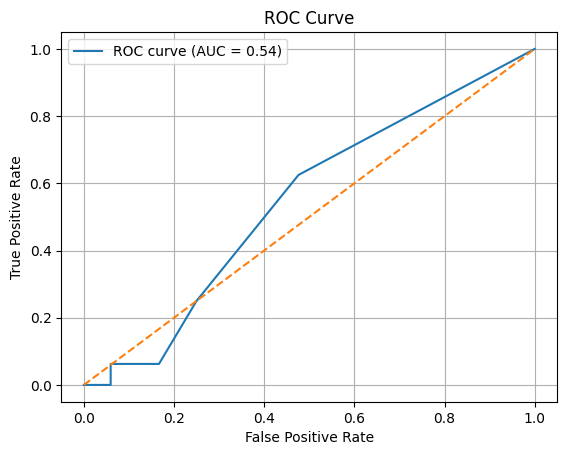

In [7]:

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


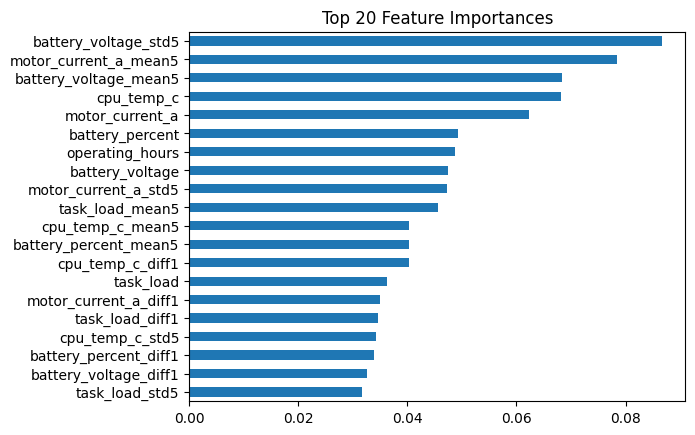

In [8]:

importances = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)[:20]
importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances')
plt.show()


In [9]:

joblib.dump(model, 'robot_failure_predictor.pkl')
print('Model saved to robot_failure_predictor.pkl')


Model saved to robot_failure_predictor.pkl
